### Simple input LIF model with integer values only

In [1]:
import sys
#sys.path.append('/home/jovyan/brian2lava')
#sys.path.append('/home/carlo/Entwicklung/Python/brian2lava')
#sys.path.append('/home/francesco/Developing/B2L/brian2lava')
#sys.path.append('/homes/jlubo/brian2lava')

In [2]:
from brian2 import *

In [3]:
# Import Brian2Lava
import brian2lava

# Use included models directory
models_dir=None

# Use external models directory (containing ncProcessModels for Loihi)
#models_dir='/home/jlubo/brian2lava-models/models'

# Set device, choosing CPU with fixed-point representation, but switching off F2F conversion
set_device('lava', mode='preset', hardware='CPU', num_repr='fixed', use_f2f=False, models_dir=models_dir)
#BrianLogger.log_level_debug()

In [4]:
# Import LIF model
from brian2lava.preset_mode.model_loader import lif

In [5]:
# Set scaling factor for fixed-point computation
scf = 1000

# Set seed
seed(1)

# Set defaultclock
defaultclock.dt = 1 * scf * ms

In [6]:
print(lif.process_name)
print(lif.description)
print(lif.equations, type(lif.equations))
print(lif.conditions)

LIF
Leaky Integrate-and-Fire neuron with exponentially decaying current input
dj/dt = -j/tau_j : V/s
dv/dt = -v/tau_v + j + bias : V
bias : V/s <class 'brian2.equations.equations.Equations'>
{'th': 'v > v_th', 'rs': 'v = v_rs'}


Model name (name of the Lava process)                                           
--------------------------------------------------------------------------------
lif                                                                             


Description                                                                     
--------------------------------------------------------------------------------
Leaky Integrate-and-Fire neuron with exponentially decaying current input       


Model equations (rendered LaTeX)                                                
--------------------------------------------------------------------------------


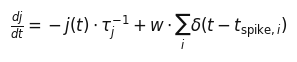

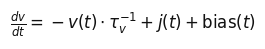

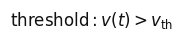

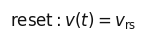



Brian 2 equations                                                               
--------------------------------------------------------------------------------
dj/dt = -j/tau_j : volt/second                                                  
dv/dt = -v/tau_v + j + bias : volt                                              
bias : volt/second                                                              


Brian 2 conditions                                                              
--------------------------------------------------------------------------------
th : v > v_th                                                                   
rs : v = v_rs                                                                   


Refractory period                                                               
--------------------------------------------------------------------------------
<not supported>


Variables                                                                       
----

In [7]:
lif.show()

In [8]:
# Define parameters
N = 3
bias_0 = 15 * mV/ms
tau_j = 0 * scf * ms
tau_v = 10 * scf * ms
v_th = 100 * scf * mV
v_rs = -5 * scf * mV
t_rp = 0 * scf * ms

# Add a spike generator group
S = SpikeGeneratorGroup(3, [0, 0], [2, 6]*second) # <--- only works with N neurons!

# Add a neuron group
P = NeuronGroup(N, lif.equations, threshold=lif.conditions["th"], reset=lif.conditions["rs"], refractory='t_rp', method='euler')
P.j = "0.0 * scf * mV/ms"
P.bias = bias_0
P.v = "2 * scf * mV"

# Add another neuron group
Q = NeuronGroup(N, lif.equations, threshold=lif.conditions["th"], reset=lif.conditions["rs"], refractory='t_rp', method='euler')
#Q.j = "0.1*mV/ms"
Q.bias = bias_0
Q.v = "2 * scf * mV"

# Add synapses
syn = Synapses(S, Q, model = 'w : volt/second', on_pre='j_post += w')
syn.connect(i=[0], j=[0,1,2])
syn.w = 50.0 * mV/ms

In [9]:
device = get_device()
device.code_object_class()

brian2.codegen.runtime.numpy_rt.numpy_rt.NumpyCodeObject

In [10]:
# Add monitor for spikes
#sm = SpikeMonitor(P)
#spmP = SpikeMonitor(P, variables='v', record=[0])
spmP = SpikeMonitor(P, variables='v', record=True)
spmQ = SpikeMonitor(Q, variables='v', record=True)

# Add monitors for voltage and current
stmPv = StateMonitor(P, variables='v', record=True)
stmPj = StateMonitor(P, variables='j', record=True)
stmQv = StateMonitor(Q, variables='v', record=True)
stmQj = StateMonitor(Q, variables='j', record=True)

In [11]:
# Run simulation
#run(15*ms)
run(30 * scf * ms)

INFO       Selected preset model 'lif' for 'neurongroup'. [brian2.devices.lava]
INFO       Encountered variable named 'delta_j' in Lava process: Assuming that this is a decay constant. Now looking in Brian script for according decay time constant 'tau_j'. [brian2.devices.lava]
INFO       Encountered variable named 'delta_v' in Lava process: Assuming that this is a decay constant. Now looking in Brian script for according decay time constant 'tau_v'. [brian2.devices.lava]
WARNING    Variable or parameter 'bias_exp' was not defined. The default value 0 from Process is used. [brian2.devices.lava]
INFO       Selected preset model 'lif' for 'neurongroup_1'. [brian2.devices.lava]
INFO       Encountered variable named 'delta_j' in Lava process: Assuming that this is a decay constant. Now looking in Brian script for according decay time constant 'tau_j'. [brian2.devices.lava]
INFO       Encountered variable named 'delta_v' in Lava process: Assuming that this is a decay constant. Now looking in

In [12]:
# #stm2.variables['v'].get_value()
print(f"P.v = {P.v/scf}")
print(f"P.j = {P.j/scf}")
print(f"Q.v = {Q.v/scf}")
print(f"Q.j = {Q.j/scf}")
#print(f"stmPv.t =\n{stmPv.t}")
#print(f"stmPv.v =\n{stmPv.v}")
#print(f"stmPj.j =\n{stmPj.j}")
#print(f"stmQv.v =\n{stmQv.v}")
#print(f"stmQj.j =\n{stmQj.j}")

P.v = [74. 74. 74.] mV
P.j = [0. 0. 0.] V/s
Q.v = [87. 87. 87.] mV
Q.j = [0. 0. 0.] V/s


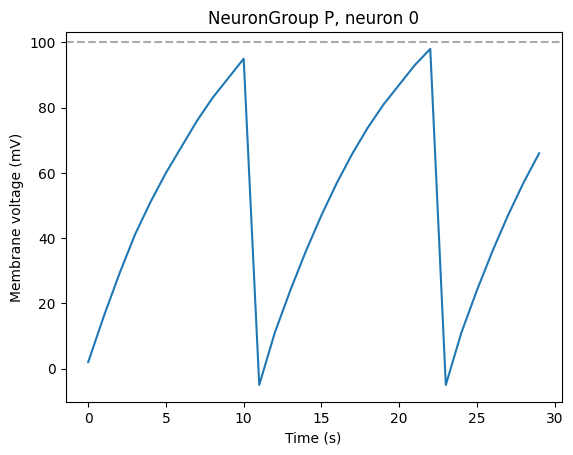

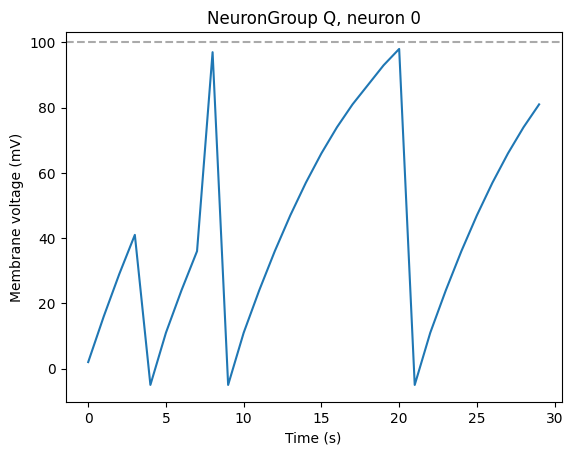

In [13]:
plt.plot(stmPv.t/second,stmPv.v[0]/mV/scf)
plt.axhline(v_th/mV/scf, linestyle="dashed", color="#aaaaaa", label='Threshold')
title('NeuronGroup P, neuron 0')
xlabel('Time (s)')
ylabel('Membrane voltage (mV)')
show()

plt.plot(stmQv.t/second,stmQv.v[0]/mV/scf)
plt.axhline(v_th/mV/scf, linestyle="dashed", color="#aaaaaa", label='Threshold')
title('NeuronGroup Q, neuron 0')
xlabel('Time (s)')
ylabel('Membrane voltage (mV)')
show()

In [14]:
print("NeuronGroup P:")
print(f"  {len(spmP.i)} spikes occurred in total, {np.sum(spmP.i == 0)} in neuron 0.")
print("  ", spmP.t[spmP.i == 0])
print("  ", spmP.v[spmP.i == 0])
print("NeuronGroup Q:")
print(f"  {len(spmQ.i)} spikes occurred in total, {np.sum(spmQ.i == 0)} in neuron 0.")
print("  ", spmQ.t[spmQ.i == 0])
print("  ", spmQ.v[spmQ.i == 0])

NeuronGroup P:
  6 spikes occurred in total, 2 in neuron 0.
   [10. 22.] s
   [95. 98.] V
NeuronGroup Q:
  9 spikes occurred in total, 3 in neuron 0.
   [ 3.  8. 20.] s
   [41. 97. 98.] V
